# The Battle of Neighborhoods - Week 2

### Introduction

The City of New York, usually called either New York City (NYC) or simply New York (NY), is the most populous city in the United States. With an estimated 2018 population of 8,398,748 distributed over a land area of about 302.6 square miles (784 km2), New York is also the most densely populated major city in the United States. Located at the southern tip of the state of New York, the city is the center of the New York metropolitan area, the largest metropolitan area in the world by urban landmass and one of the world's most populous megacities, with an estimated 19,979,477 people in its 2018 Metropolitan Statistical Area and 22,679,948 residents in its Combined Statistical Area. A global power city, New York City has been described as the cultural, financial, and media capital of the world, and exerts a significant impact upon commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports. 62.85% of New York City residents were born in the United States, with 48.29% having been born in New York. 16.67% of residents are not US citizens. Of those not born in the United States, the largest percentage are from Latin America

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighbourhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighbourhoods such as Flushing, Sunset Park, and Corona.

With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Mexican, and French etc.


## Problem Statement

One of my client is looking to setup a mexican restaurant in NYC. He would like to narrow down the neighbourhood of NYC through a data driven approach along with his interaction with industry experts, vendors and other stake holders. As an analyst, i would like to explore the best mexican restaurants in NYC. So as part of this project, we will list and visualize all major parts of New York City that has great Mexican restaurants along with narrowing down on a neighbourhood for potential oppurtunity for an mexican restaurant.

### Data 
For this project we need the following data:
<ul>
<li> New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude.
    <ul>
        <li>Data source : https://cocl.us/new_york_dataset
        <li> Description : This data set contains the required information. And we will use this data set to explore various neighbourhoods of New York City.
     </ul>
<li> Mexican restaurants in each neighbourhood of New York City.
        <ul>
        <li>Data source : Fousquare API
        <li> Description : By using this api we will get all the venues in each neighbourhood. We can filter these venues to get only Mexican restaurants.
     </ul>
<li> GeoSpace data
          <ul>
        <li>Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
        <li> Description : By using this geo space data we will get the New York Borough boundaries that will help us visualize choropleth map.
  
</ul>


### Approach or Methodology
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Mexican Resturants.
- Find rating , tips and like count for each Mexican Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Questions that can be asked using the above mentioned datasets
- What is best location in New York City for Mexican Cuisine ? 
- Which areas have potential Mexican Resturant Market ? 
- Which all areas lack Mexican Resturants ?
- Which is the best place to stay if I prefer Mexican Cuisine ?

### Analysis

We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [28]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
!conda install -c conda-forge geopy --yes 
#!pip install geocoder
import geocoder
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [29]:

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given  latitude and longitude. Below function will return us the venue id , venue name and category.

In [30]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SC0F4RRIQKEO5LT3TFCDFLYOE1JCCKB3NWDGTWQPDCPMSDTF' # your Foursquare ID
    CLIENT_SECRET = 'R2BNL2LV0EVF5G03GIFASMKS0ENZANFITVKVDSQOEINAIS2C' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

In [31]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'SC0F4RRIQKEO5LT3TFCDFLYOE1JCCKB3NWDGTWQPDCPMSDTF' # your Foursquare ID
    CLIENT_SECRET = 'R2BNL2LV0EVF5G03GIFASMKS0ENZANFITVKVDSQOEINAIS2C' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [33]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [25]:
# get new york data
new_york_data=get_new_york_data()

In [26]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [27]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

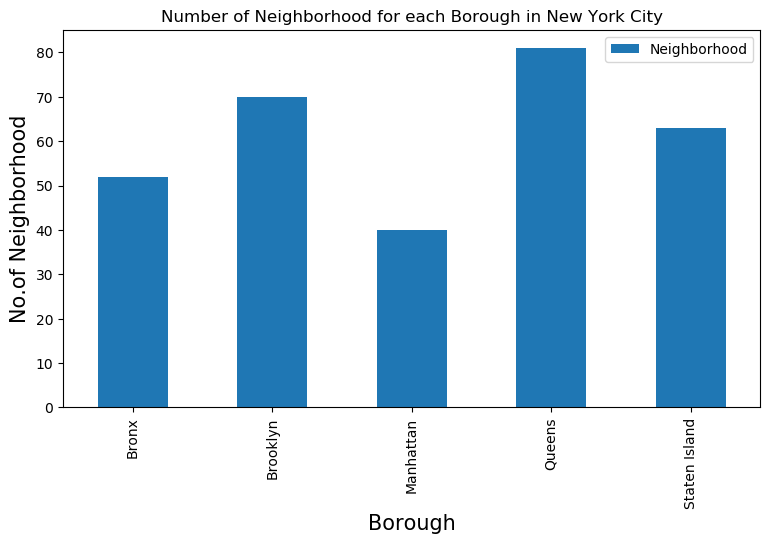

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Mexican resturants for each Neighborhood

In [36]:
# prepare neighborhood list that contains Mexican resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
mexican_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    mexican_resturants=venues[venues['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(new_york_data),')','Mexican Resturants in '+Neighborhood+', '+Borough+':'+str(len(mexican_resturants)))
    for resturant_detail in mexican_resturants.values.tolist():
        id, name , category=resturant_detail
        mexican_rest_ny = mexican_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Mexican Resturants in Wakefield, Bronx:0
( 2 / 306 ) Mexican Resturants in Co-op City, Bronx:2
( 3 / 306 ) Mexican Resturants in Eastchester, Bronx:0
( 4 / 306 ) Mexican Resturants in Fieldston, Bronx:3
( 5 / 306 ) Mexican Resturants in Riverdale, Bronx:2
( 6 / 306 ) Mexican Resturants in Kingsbridge, Bronx:6
( 7 / 306 ) Mexican Resturants in Marble Hill, Manhattan:4
( 8 / 306 ) Mexican Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Mexican Resturants in Norwood, Bronx:3
( 10 / 306 ) Mexican Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Mexican Resturants in Baychester, Bronx:2
( 12 / 306 ) Mexican Resturants in Pelham Parkway, Bronx:1
( 13 / 306 ) Mexican Resturants in City Island, Bronx:0
( 14 / 306 ) Mexican Resturants in Bedford Park, Bronx:3
( 15 / 306 ) Mexican Resturants in University Heights, Bronx:0
( 16 / 306 ) Mexican Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Mexican Resturants in Fordham, Bronx:1
( 18 / 306 ) Mexican Resturants in East Tremont, Bronx:

Now that we have got all the mexican resturants in new york city , we will analyze it

In [37]:
mexican_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar
4,Bronx,Fieldston,5ce9664e3731ee002baae6ed,Estrellita Poblana


In [39]:
mexican_rest_ny.shape

(328, 4)

We got 328 Mexican Resturants across New York City

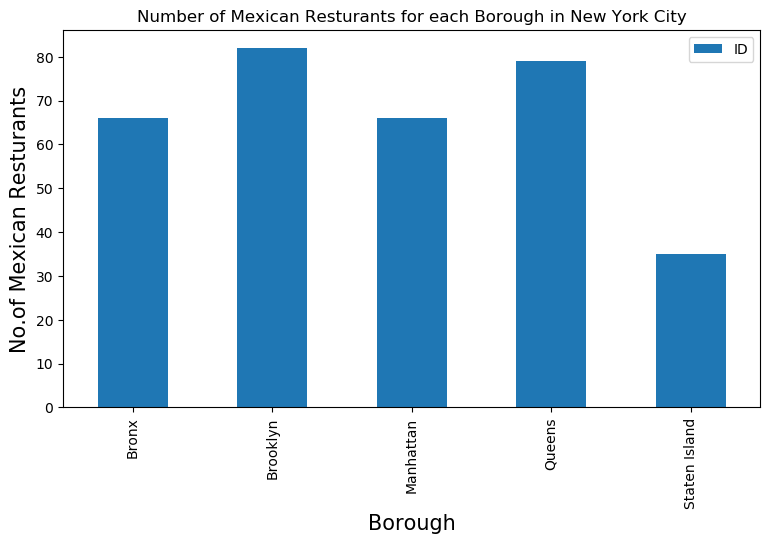

In [41]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Mexican Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Mexican Resturants', fontsize=15)
#giving a bar plot
mexican_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Brooklyn has the largest number of mexican resturants

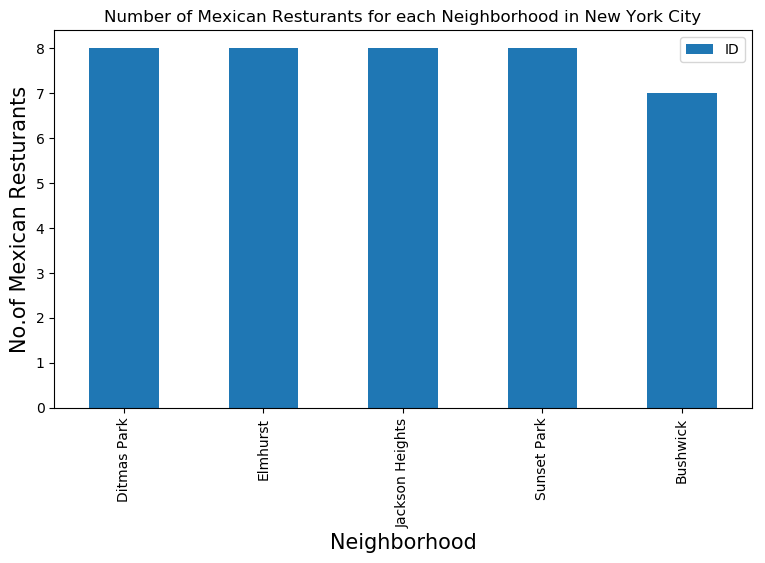

In [42]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Mexican Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Mexican Resturants', fontsize=15)
#giving a bar plot
mexican_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [44]:
mexican_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5)

Neighborhood
Ditmas Park        8
Elmhurst           8
Jackson Heights    8
Sunset Park        8
Bushwick           7
Name: ID, dtype: int64

In [46]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='Ditmas Park']

,Borough,Neighborhood,ID,Name
261,Brooklyn,Ditmas Park,596938a0a22db76efcd439a6,Los Tres Chiflados
262,Brooklyn,Ditmas Park,4ad123f7f964a52003dd20e3,Cinco de Mayo
263,Brooklyn,Ditmas Park,52b1cc13498e28159d0fadb8,El Paso Mexican Grill
264,Brooklyn,Ditmas Park,5491cc2b498ea98016a548b2,Mallenche Mexican Grill
265,Brooklyn,Ditmas Park,4b79ee38f964a520f31a2fe3,El Ranchito Poblano
266,Brooklyn,Ditmas Park,57b3b186498ef68837df6be3,Mexico Diner
267,Brooklyn,Ditmas Park,4b5111c2f964a520b44027e3,Los Mariachis
268,Brooklyn,Ditmas Park,4b92e166f964a520062434e3,Don Burrito


So Ditmas Park in Brooklyn has the highest number of Mexican Resturants with a total count of 8.

Now we will get the ranking of each resturant for further analysis.

In [47]:
# prepare neighborhood list that contains Mexican resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mexican_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in mexican_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(mexican_rest_ny),')','processed')
    mexican_rest_stats_ny = mexican_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                    Name  Likes  Rating  Tips
0  5c47a4b21953f3002c558218  Chipotle Mexican Grill      0     7.5     0
( 1 / 328 ) processed
                         ID                   Name  Likes  Rating  Tips
0  58582b156431e554e165d909  Moe's Southwest Grill      1     6.6     0
( 2 / 328 ) processed
                         ID          Name  Likes  Rating  Tips
0  523f6e14498ef6fdefc0d690  Burrito Shop     10     6.9     4
( 3 / 328 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4b78ba71f964a5209fdf2ee3  Santa Fe Grill & Bar     11     6.3    17
( 4 / 328 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5ce9664e3731ee002baae6ed
( 5 / 328 ) processed
                         ID           Name  Likes  Rating  Tips
0  590e5d2ce96d0c61de2dcf1d  Cocina Chente     13     8.9     5
( 6 / 328 ) processed
                         ID    Name  Likes  Rating  Tips
0  4db4

KeyError: 'venue'

In [48]:
mexican_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill,0,7.5,0
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill,1,6.6,0
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop,10,6.9,4
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar,11,6.3,17
4,Bronx,Fieldston,0,0,0,0.0,0


In [49]:
mexican_rest_stats_ny.shape

(50, 7)

In [50]:
mexican_rest_ny.shape

(328, 4)

So we got data for all resturants
Now lets save this data to a csv sheet. In case we by mistake modify it.
As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [51]:
mexican_rest_stats_ny.to_csv('mexican_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [52]:
mexican_rest_stats_ny_csv=pd.read_csv('mexican_rest_stats_ny.csv')

In [53]:
mexican_rest_stats_ny_csv.shape

(50, 7)

In [54]:
mexican_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill,0,7.5,0
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill,1,6.6,0
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop,10,6.9,4
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar,11,6.3,17
4,Bronx,Fieldston,0,0,0,0.0,0


In [55]:
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [56]:
mexican_rest_stats_ny['Likes']=mexican_rest_stats_ny['Likes'].astype('float64')

In [57]:
mexican_rest_stats_ny['Tips']=mexican_rest_stats_ny['Tips'].astype('float64')

In [58]:
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


Now the data types looks correct

In [59]:
# Resturant with maximum Likes
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                130
Rating                               9.1
Tips                                  72
Name: 43, dtype: object

In [60]:
# Resturant with maximum Rating
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                130
Rating                               9.1
Tips                                  72
Name: 43, dtype: object

In [83]:
# Resturant with maximum Tips
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                130
Rating                               9.1
Tips                                  72
Name: 43, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [84]:
ny_neighborhood_stats=mexican_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [92]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
20,Westchester Square,8.500000
12,Morris Park,8.500000
16,Parkchester,8.400000
14,Mott Haven,8.400000
7,High Bridge,8.000000
18,Riverdale,7.750000
13,Morrisania,7.750000
8,Kingsbridge,7.733333
11,Melrose,7.716667
2,Belmont,7.650000


Above are the top neighborhoods with top average rating of mexican resturants

In [90]:
ny_borough_stats=mexican_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [91]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,6.630435
1,Manhattan,6.100000


Similarly these are the average rating of mexican Resturants for each Borough

Lets visualize it

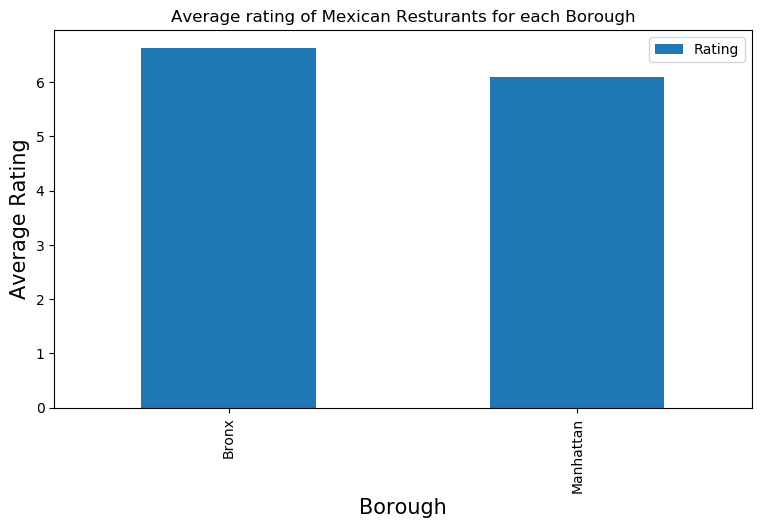

In [76]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Mexican Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
mexican_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [89]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=1.0]

In [80]:
ny_neighborhood_stats

,Neighborhood,Average Rating


We will join this dataset to original new york data to get lonitude and latitude

In [93]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [94]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [95]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Baychester,40.866858,-73.835798,7.050000
1,Bronx,Bedford Park,40.870185,-73.885512,4.800000
2,Bronx,Belmont,40.857277,-73.888452,7.650000
3,Bronx,Co-op City,40.874294,-73.829939,7.050000
4,Bronx,Country Club,40.844246,-73.824099,3.900000
5,Bronx,Fieldston,40.895437,-73.905643,4.400000
6,Bronx,Fordham,40.860997,-73.896427,6.700000
7,Bronx,High Bridge,40.836623,-73.926102,8.000000
8,Bronx,Kingsbridge,40.881687,-73.902818,7.733333
9,Bronx,Longwood,40.815099,-73.895788,6.950000


Now we will show this data on a map

In [34]:
# create map and display it

ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [33]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [110]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Lets add a new field to dataframe for labeling purpose

In [111]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [112]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
<br>Lets Visualize Boroughs based on average Rating

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file


### Results 
- Westchester Square(Bronx), Morris Park(Bronx), Marble Hill(Manhattan) are some of the best neighborhoods for Mexican cuisine. 
- Manhattan have potential Mexican Resturant Market
- Staten Island	ranks last in average rating of Mexican Resturants.
- Bronx is the best place to stay if you prefer Mexican Cuisine.
- Ditmas Park, Elmhurst, Jackson Heights neighbourhoods has 8 Mexican restaurants
- Taqueria Tlaxcali in Bronx is highly liked & rated restaurant
- Taqueria Tlaxcali in Bronx is also highly tipped restaurant

### Discussions
- It is recommended that Manhattan would be the best choice to open an mexican restaurant preferably in a truck instead of spending high rentals in Manhattan.
- The ranking is purely on basis of rating of resturants
- The accuracy of data depends purely depends on the data provided by FourSquare
- Scope of the study is very limited due to various demographics factor
